In [8]:
import re
from collections import defaultdict
import ast
## PLACE LOG FILE HERE
log_path = "shankar_cp_timing.txt"

# updated patterns
patterns = {
    # "prefill_receive":     re.compile(r"SHRI Prefill Request (\S+)"),
    # "decode_receive":      re.compile(r"SHRI Decode Request (\S+)"),


    # "phase_1": re.compile(r"ROHAN Start of execute_model ({.*?})"), #shared by both
    # "phase_2":     re.compile(r"ROHAN Model Runner Before Recv KV \(Phase 2\): ({.*?})"), #shared by both
    # "phase_3": re.compile(r"ROHAN GPU Request Resume \(Phase 3\): ({.*?})"), #shared by both
    # "phase_4":     re.compile(r"ROHAN Model Runner Before Send KV \(Phase 4\): ({.*?})"), #shared by both
    # "phase_5":      re.compile(r"ROHAN Model Runner After Send KV \(Phase 5\): ({.*?})"), #shared by both
    # "phase_6":   re.compile(r"ROHAN End of execute_model ({.*?})"), #shared by both

    "phase_1": re.compile(
        r"ROHAN Start of execute_model\s*"
        r"\(PID:\s*(?P<pid>\d+)\)\s*"
        r"\(is prefill:\s*(?P<prefill>True|False)\)\s*"
        r"\(Phase 1\):\s*(?P<payload>\{.*?\})"
    ),
    "phase_6": re.compile(
        r"ROHAN End of execute_model\s*"
        r"\(PID:\s*(?P<pid>\d+)\)\s*"
        r"\(is prefill:\s*(?P<prefill>True|False)\)\s*"
        r"\(Phase 6\):\s*(?P<payload>\{.*?\})"
    ),


    "req_start": re.compile(
        r"ROHAN Start of Engine Step Request ID: (?P<reqid>\S+)"
        r" ON PID: (?P<pid>\d+)"
        r" at: (?P<ts>\d+\.\d+)"
    ),
    "req_end": re.compile(
        r"SHRI Finished Request ID (?P<reqid>\S+)"
        r" at (?P<ts>\d+\.\d+)"
        r" on PID: (?P<pid>\d+)"
    ),
}

# regex to extract the Unix‐style float timestamp
# still use a simple float‐timestamp puller for the other phases
ts_re = re.compile(r"(\d+\.\d+)")

def extract_events(log_file_path):
    # pid_map maps each PID to its three event‐dicts
    pid_map: dict[str, dict[str, defaultdict]] = {}

    with open(log_file_path) as f:
        for line in f:
            for name, pat in patterns.items():
                m = pat.search(line)
                if not m:
                    continue

                pid = m.group("pid")
                # initialize per‐PID buckets on first sight
                if pid not in pid_map:
                    pid_map[pid] = {
                        "prefill_events": defaultdict(list),
                        "decode_events":  defaultdict(list),
                        "request_events": defaultdict(list),
                    }
                ev_pref = pid_map[pid]["prefill_events"]
                ev_dec  = pid_map[pid]["decode_events"]
                ev_req  = pid_map[pid]["request_events"]

                # get timestamp
                if name in ("req_start", "req_end"):
                    ts = float(m.group("ts"))
                else:
                    # fallback to ts_re for phase_1/6
                    tsm = ts_re.search(line)
                    if not tsm:
                        break
                    ts = float(tsm.group(1))

                if name in ("phase_1", "phase_6"):
                    is_prefill = (m.group("prefill") == "True")
                    ids = list(ast.literal_eval(m.group("payload")).keys())
                    target = ev_pref if is_prefill else ev_dec
                    target[name].append((ts, ids))
                else:
                    # req_start / req_end → just record the timestamp
                    ev_req[name].append(ts)

                break  # stop after first matching pattern

    # sort each list by timestamp
    for pid, evs in pid_map.items():
        for d in (evs["prefill_events"], evs["decode_events"]):
            for k in d:
                d[k].sort(key=lambda x: x[0])
        for k in evs["request_events"]:
            evs["request_events"][k].sort()

    return pid_map


def compute_intervals(events, first_time_offset=0):
    intervals = [
        (start[0] - first_time_offset, end[0] - first_time_offset)
        for start, end in zip(events['phase_1'], events['phase_6'])
    ]


    return intervals

In [9]:
import matplotlib.pyplot as plt

def plot_combined_intervals(dict1, dict2, label1="Run 1", label2="Run 2", xmin=None, xmax=None):
    fig, ax = plt.subplots(figsize=(50, 6))

    combined = {}

    # Merge both dicts with prefixes to distinguish them
    for k, v in dict1.items():
        combined[f"{label1}: {k}"] = v
    for k, v in dict2.items():
        combined[f"{label2}: {k}"] = v

    keys = list(combined.keys())

    # Hardcoded color map for known phases (extend if needed)
    color_map = {
        'kv_send_comm': 'red',
        'kv_recv_comm': 'blue',
    }

    all_starts = [start for intervals in combined.values() for start, _ in intervals]
    all_ends   = [end for intervals in combined.values() for _, end in intervals]
    xmin = xmin if xmin is not None else min(all_starts)
    xmax = xmax if xmax is not None else max(all_ends)

    yticks = []
    ylabels = []

    for i, key in enumerate(keys):
        # Strip prefix to check base name for color mapping
        base_key = key.split(": ")[-1]
        color = color_map.get(base_key, f"C{i}")  # fallback: distinct default color
        for start, end in combined[key]:
            ax.barh(y=i, width=end - start, left=start, height=0.4, color=color)
        yticks.append(i)
        ylabels.append(key)

    ax.set_xlim(xmin, xmax)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Time (s)")
    ax.set_title("Combined Timeline of Events")
    plt.tight_layout()
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.show()

132
186
defaultdict(<class 'list'>, {'phase_1': [(1745981619.9985225, ['cmpl-6f6764401b374b6f9d1080351a2b0a15-0']), (1745981620.1118388, ['cmpl-6f6764401b374b6f9d1080351a2b0a15-0']), (1745981620.6881716, ['cmpl-6f6764401b374b6f9d1080351a2b0a15-0']), (1745981620.8237383, ['cmpl-6f6764401b374b6f9d1080351a2b0a15-0']), (1745981620.9761896, ['cmpl-6f6764401b374b6f9d1080351a2b0a15-0']), (1745981621.1416247, ['cmpl-71a795a7ca7843b3b187223f6005c114-0', 'cmpl-6f6764401b374b6f9d1080351a2b0a15-0']), (1745981621.2726696, ['cmpl-71a795a7ca7843b3b187223f6005c114-0', 'cmpl-6f6764401b374b6f9d1080351a2b0a15-0']), (1745981621.4054537, ['cmpl-71a795a7ca7843b3b187223f6005c114-0', 'cmpl-6f6764401b374b6f9d1080351a2b0a15-0']), (1745981621.5494866, ['cmpl-71a795a7ca7843b3b187223f6005c114-0', 'cmpl-6f6764401b374b6f9d1080351a2b0a15-0']), (1745981622.7010615, ['cmpl-71a795a7ca7843b3b187223f6005c114-0', 'cmpl-6f6764401b374b6f9d1080351a2b0a15-0']), (1745981622.8652606, ['cmpl-739f8c21535b48b495bd5838c8a68484-0', '

/tmp/ipykernel_480296/2136352976.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('Accent', len(pid_to_intervals))


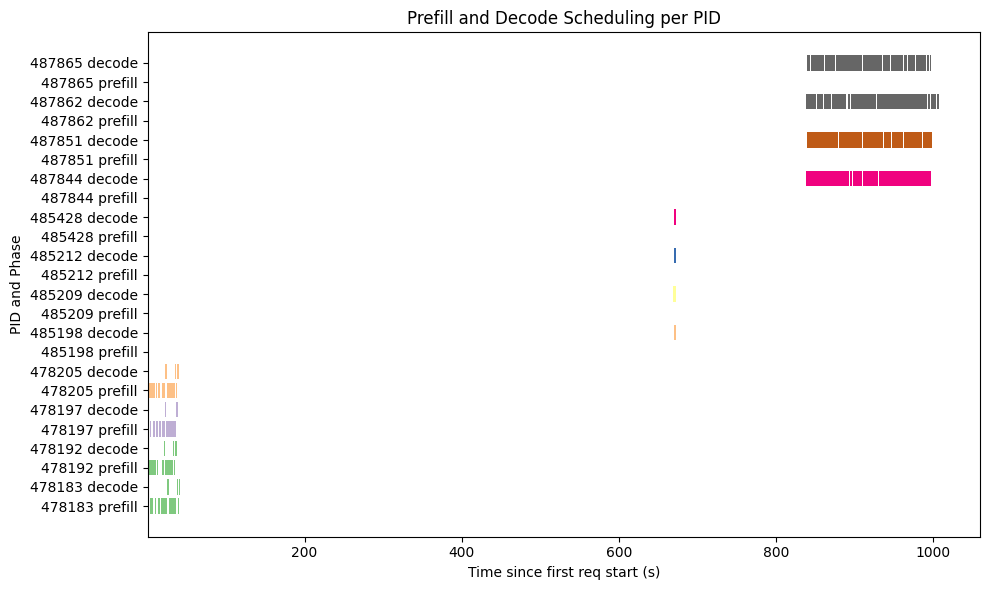

In [10]:
if __name__ == "__main__":
    pid_map = extract_events(log_path)
    first_time_offset = min([pid_map[p]["request_events"]["req_start"][0] for p in pid_map ])
    
    pid_to_intervals: dict[str, dict[str, list]] = {}

    for pid, data in pid_map.items():
        prefill_events = data["prefill_events"]
        decode_events = data["decode_events"]
        request_events = data["request_events"]

        # compute_intervals takes your { phase: [(ts, ids), …], … } and the offset
        prefill_intervals = compute_intervals(prefill_events, first_time_offset)
        decode_intervals = compute_intervals(decode_events, first_time_offset)
        print(len(prefill_events["phase_1"]))
        print(len(decode_events["phase_1"]))
        print(prefill_events)
        pid_to_intervals[pid] = {
            "prefill_intervals": prefill_intervals,
            "decode_intervals": decode_intervals,
            # if you also want the raw req timestamps handy:
            "req_start": request_events.get("req_start", []),
            "req_end": request_events.get("req_end", []),
        }
    # collapsed_decode_intervals = {}
    # collapsed_prefill_intervals["GPU_TIME"] = prefill_intervals["phase_1_2"] + prefill_intervals["phase_3_4"] + prefill_intervals["phase_5_6"]
    # collapsed_prefill_intervals["COMMUNICATION_TIME"] = prefill_intervals["kv_send_comm"] + prefill_intervals["kv_recv_comm"]
    # collapsed_decode_intervals["GPU_TIME"] = decode_intervals["phase_1_2"] + decode_intervals["phase_3_4"] + decode_intervals["phase_5_6"]
    # collapsed_decode_intervals["COMMUNICATION_TIME"] = decode_intervals["kv_send_comm"] + decode_intervals["kv_recv_comm"]

    # print(collapsed_decode_intervals["COMMUNICATION_TIME"])
    # # print counts & average durations
    # # for name, durs in intervals.items():
    # #     print(name, durs)
    # #     if not durs:
    # #         continue
    # #     avg = sum(durs) / len(durs)
    # #     print(f"{name:20s}: count={len(durs):3d}, avg={avg:.6f}s, min={min(durs):.6f}s, max={max(durs):.6f}s")
    # plot_combined_intervals(
    #     dict1=collapsed_decode_intervals,
    #     dict2=collapsed_prefill_intervals,
    #     label1="Decode",
    #     label2="Prefill",
    #     xmin=0,
    #     xmax=last_time_offset - first_time_offset
    # )
fig, ax = plt.subplots(figsize=(10, 6))

y_positions = []
y_labels = []

# Pick a distinct color per PID
color_map = plt.cm.get_cmap('Accent', len(pid_to_intervals))

for i, (pid, intervals) in enumerate(sorted(pid_to_intervals.items())):
    base = i * 2
    pid_color = color_map(i)

    # Prefill bars
    for start, end in intervals['prefill_intervals']:
        ax.barh(base, end - start, left=start, color=pid_color)
    y_positions.append(base)
    y_labels.append(f"{pid} prefill")

    # Decode bars
    for start, end in intervals['decode_intervals']:
        ax.barh(base + 1, end - start, left=start, color=pid_color)
    y_positions.append(base + 1)
    y_labels.append(f"{pid} decode")

ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels)
ax.set_xlabel('Time since first req start (s)')
ax.set_ylabel('PID and Phase')
ax.set_title('Prefill and Decode Scheduling per PID')
plt.tight_layout()
plt.show()

In [11]:
#not checking for overlap
import matplotlib.pyplot as plt

def plot_timeline_per_dict_with_phase_colors(dict1, dict2, label1="Baseline", label2="Optimized", xmin=None, xmax=None):
    fig, ax = plt.subplots(figsize=(50, 6))

    # Assign unique colors for each (dict, key) pair
    color_map = {
        (label1, 'GPU_TIME'): 'red',
        (label1, 'COMMUNICATION_TIME'): 'blue',
        (label2, 'GPU_TIME'): 'green',
        (label2, 'COMMUNICATION_TIME'): 'orange',
    }

    # Flatten intervals with source labels
    all1 = [(label1, k, interval) for k, intervals in dict1.items() for interval in intervals]
    all2 = [(label2, k, interval) for k, intervals in dict2.items() for interval in intervals]

    all_starts = [start for _, _, (start, _) in all1 + all2]
    all_ends   = [end for _, _, (_, end) in all1 + all2]
    xmin = xmin if xmin is not None else min(all_starts)
    xmax = xmax if xmax is not None else max(all_ends)

    # Plot Baseline on y=0, Optimized on y=1
    for label, key, (start, end) in all1:
        color = color_map.get((label, key), 'gray')
        ax.barh(y=0, width=end - start, left=start, height=0.4, color=color)

    for label, key, (start, end) in all2:
        color = color_map.get((label, key), 'gray')
        ax.barh(y=1, width=end - start, left=start, height=0.4, color=color)

    ax.set_yticks([0, 1])
    ax.set_yticklabels([label1, label2])
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel("Time (s)")
    ax.set_title("Timeline: Each (Run, Phase) in Unique Color")
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Create a manual legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for (_, _), color in color_map.items()]
    labels = [f"{run} - {phase}" for (run, phase) in color_map]
    ax.legend(handles, labels, title="Source + Phase")

    plt.show()


plot_timeline_per_dict_with_phase_colors(
        dict1=collapsed_decode_intervals,
        dict2=collapsed_prefill_intervals,
        label1="Decode",
        label2="Prefill",
        xmin=0,
        xmax=last_time_offset - first_time_offset
)

NameError: name 'collapsed_decode_intervals' is not defined